Notebook for Extracting patches and annotations from Monkey Dataset

In [56]:
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.tools.patchextraction import get_patch_extractor
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re

In [55]:
def extract_id(file_name:str):
    """
    Give a file name such as 'A_P000001_PAS_CPG.tif',
    Extract the ID: 'A_P000001'
    """
    match = re.match(r'([A-Z]_P\d+)_', file_name, re.IGNORECASE)
    
    if match:
        return match.group(1)
    else:
        return None


def parse_json_annotations(json_path: str):
    """Extract annotations from json file"""
    with open(json_path, 'r') as f:
        annotations = json.load(f)
    return annotations["points"]

def filter_points_with_bb(points_dict, bb):
    selected_points = []
    for item in points_dict:
        point = item['point']
        if bb[0] <= point[0] and bb[1] <= point[1] and bb[2] >= point[0] and bb[3] >= point[1]:
            selected_points.append(point)
    return selected_points

In [2]:
# Path to folder containing all the target WSIs
images_folder = "/home/u1910100/Downloads/Monkey/images/pas-cpg"
# Path to folder containing masks for ROIs for each WSI
tissue_masks_folder = "/home/u1910100/Downloads/Monkey/images/tissue-masks"
# Path to folder containing annotation json files
annotations_folder = "/home/u1910100/Downloads/Monkey/annotations/json"

|2024-10-04|15:58:14.279| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-10-04|15:58:14.280| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


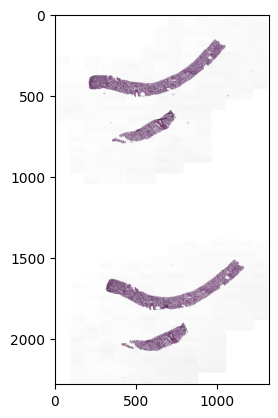

|2024-10-04|15:58:14.524| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-10-04|15:58:14.524| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


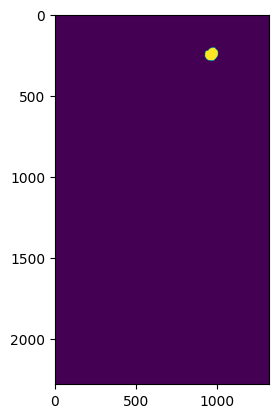

In [60]:
# Path to folder containing all the target WSIs
images_folder = "/home/u1910100/Downloads/Monkey/images/pas-cpg"
# Path to folder containing masks for ROIs for each WSI
tissue_masks_folder = "/home/u1910100/Downloads/Monkey/images/tissue-masks"
# Path to folder containing annotation json files
annotations_folder = "/home/u1910100/Downloads/Monkey/annotations/json"

for wsi_image_name in os.listdir(images_folder):
    wsi_id = extract_id(wsi_image_name)

    # Annotation file names and paths
    inflammatory_json_name = f"{wsi_id}_inflammatory-cells.json"
    lymphocyte_json_name = f"{wsi_id}_lymphocytes.json"
    monocyte_json_name = f"{wsi_id}_monocytes.json"
    
    inflammatory_json_path = os.path.join(annotations_folder, inflammatory_json_name)
    lymphocytes_json_path = os.path.join(annotations_folder, lymphocyte_json_name)
    monocyte_json_path = os.path.join(annotations_folder, monocyte_json_name)

    inflammatory_points = parse_json_annotations(inflammatory_json_path)

    # WSI path and tissue mask path
    wsi_path = os.path.join(images_folder, wsi_image_name)
    
    mask_name = f"{wsi_id}_mask.tif"
    mask_path = os.path.join(tissue_masks_folder, mask_name)
    
    # Read WSI and tissue mask
    wsi_reader = WSIReader.open(wsi_path)
    thumb = wsi_reader.slide_thumbnail()
    plt.imshow(thumb)
    plt.show()
    mask_reader = WSIReader.open(mask_path)
    mask_thumbnail = mask_reader.slide_thumbnail()
    binary_mask = mask_thumbnail[:,:,0]
    plt.imshow(binary_mask)
    plt.show()
    break

    # Extract patches
    patch_extractor = get_patch_extractor(
        input_img=wsi_reader,
        input_mask = binary_mask,
        method_name="slidingwindow",
        patch_size=(256, 256),
        stride=(224,224),
        resolution=40,
        units="power",
    )
    for idx, patch in enumerate(patch_extractor):
        bb = patch_extractor.coordinate_list[idx]
        print(bb)
        plt.imshow(patch)
        plt.show()

        inflammatory_coords = filter_points_with_bb(inflammatory_points, bb)
        print(inflammatory_coords)

        relative_x_coords = [int(item[0] - bb[0])  for item in inflammatory_coords]
        relative_y_coords = [int(item[1] - bb[1])  for item in inflammatory_coords]
        print(relative_y_coords, relative_x_coords)

        mask_patch = mask_reader.read_bounds(
            bb, resolution=40,
            units="power",
        )
        masked_patch = patch * mask_patch
        plt.imshow(masked_patch)
        plt.scatter(relative_x_coords, relative_y_coords, c='r')
        plt.show()
    break

In [ ]:
inflammatory_json_name = "A_P000001_inflammatory-cells.json"
inflammatory_json_path = os.path.join(annotations_folder, inflammatory_json_name)
inflammatory_points = parse_json_annotations(inflammatory_json_path)

In [ ]:
wsi_name = "A_P000001_PAS_CPG.tif"
wsi_name_without_ext = os.path.splitext(wsi_name)[0]
wsi_path = os.path.join(images_folder, wsi_name)


wsi_reader = WSIReader.open(wsi_path)
print(wsi_reader.info.as_dict())

In [ ]:
thumbnail = wsi_reader.slide_thumbnail(resolution=1.25, units='power')
plt.imshow(thumbnail)
plt.show()

In [ ]:
mask_name = "A_P000001_mask.tif"
mask_path = os.path.join(tissue_masks_folder, mask_name)
mask_reader = WSIReader.open(mask_path)

mask_thumbnail = mask_reader.slide_thumbnail()
binary_mask = mask_thumbnail[:,:,0]
print(binary_mask.shape)
plt.imshow(binary_mask)
plt.show()

In [22]:
patch_extractor = get_patch_extractor(
    input_img=wsi_reader,
    input_mask = binary_mask,
    method_name="slidingwindow",
    patch_size=(256, 256),
    stride=(224,224),
    resolution=40,
    units="power",
)
print(len(patch_extractor))

In [ ]:
idx = 118
patch = patch_extractor[idx]
bb = patch_extractor.coordinate_list[idx]
print(bb)
plt.imshow(patch)
plt.show()

inflammatory_coords = filter_points_with_bb(inflammatory_points, bb)
print(inflammatory_coords)

relative_x_coords = [int(item[0] - bb[0])  for item in inflammatory_coords]
relative_y_coords = [int(item[1] - bb[1])  for item in inflammatory_coords]
print(relative_y_coords, relative_x_coords)

mask_patch = mask_reader.read_bounds(
    bb, resolution=40,
    units="power",
)
# plt.imshow(mask_patch[:,:,0])
# plt.show()

masked_patch = patch * mask_patch
plt.imshow(masked_patch)
plt.scatter(relative_x_coords, relative_y_coords, c='r')
plt.show()